### Objetivo 

Este notebook tem por objetivo a lancar luz à questão trazida no case: **Identifique qual é a causa raiz do problema apresentado e informe à equipe se eles devem interromper todos os investimentos ou se existe um plano B que eles possam seguir para continuar aumentando os pedidos.**

In [638]:
# Importar as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from src.paths import DATA_INPUTS_OUTPUTS, IMAGES
from src import utils

# Auto reload da lib src
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parâmetros matplotlib
plt.style.use('bmh')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
pd.set_option('display.max_columns', 366)

In [158]:
# Carregar os dados
Order_rating_DB = pd.read_csv(DATA_INPUTS_OUTPUTS / 'OrderRatingDB.csv')
Bad_rating_reasons = pd.read_excel(DATA_INPUTS_OUTPUTS / 'Data Analyst _ Zé Delivery Data Base.xlsx', sheet_name='Bad Rating reasons')

# Tipagem coluna de data
Order_rating_DB['Date&Time'] = pd.to_datetime(Order_rating_DB['Date&Time'])

In [639]:
# Adicionar colunas
Order_rating_DB['date'] = pd.to_datetime(Order_rating_DB['Date&Time'].dt.date)
Order_rating_DB['hour'] = Order_rating_DB['Date&Time'].dt.hour
Order_rating_DB['day'] = Order_rating_DB['Date&Time'].dt.day
Order_rating_DB['month'] = Order_rating_DB['Date&Time'].dt.month
Order_rating_DB['month-day'] = Order_rating_DB['Date&Time'].dt.strftime('%m%d')

# Período do dia
bins = [0, 6, 12, 18, 25]
labels = ['0h-6h','6h-12h','12h-18h','18h-24h']
Order_rating_DB['PeriodOfDay'] = pd.cut(Order_rating_DB['hour'], bins=bins, labels=labels, right=False)

# Nome do dia da semana
Order_rating_DB['DayOfWeek'] = utils.day_of_week(Order_rating_DB)

In [359]:
# Tamanho do dataset
Order_rating_DB.shape

(11257, 25)

In [360]:
# Tipo dos dados
Order_rating_DB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11257 entries, 0 to 11256
Data columns (total 25 columns):
OrderID               11257 non-null int64
OrderNumber           11257 non-null int64
Week                  11257 non-null int64
Date&Time             11257 non-null datetime64[ns]
Comment               127 non-null object
User                  11257 non-null object
MerchandiseRevenue    11257 non-null float64
PaymentMethod         5988 non-null object
POCID                 11257 non-null int64
Rating                5134 non-null float64
Reasons               0 non-null float64
ShippingType          11257 non-null object
State                 11237 non-null object
CorrectWeek           11257 non-null int64
CorrectState          11237 non-null object
date                  11257 non-null datetime64[ns]
hour                  11257 non-null int64
day                   11257 non-null int64
month                 11257 non-null int64
month-day             11257 non-null object
PeriodOf

___

#### Existe uma queda?

In [361]:
# Conforme orientações, -1, 0 ou em branco não são considerados na classificação média de pedidos
filtro = [-1,0,np.nan]
respostas = Order_rating_DB[~Order_rating_DB['Rating'].isin(filtro)].copy()
respostas.sample(5)

,OrderID,OrderNumber,Week,Date&Time,Comment,User,MerchandiseRevenue,PaymentMethod,POCID,Rating,Reasons,ShippingType,State,CorrectWeek,CorrectState,date,hour,day,month,month-day,PeriodOfDay,StatusRating,QtdeCompras,QtdeComprasLabel,DayOfWeek
4088,225233,47912,24,2017-06-06 21:26:43,NaN,user672gmail.com,28.680,NaN,30,5.0,NaN,receber,SP,23,SP,2017-06-06,21,6,6,0606,18h-24h,Respondeu,3,3x ou mais,2 Terca
7395,111870,21881086,35,2017-08-25 17:37:22,NaN,user23019gmail.com,32.448,Dinheiro,49,5.0,NaN,receber,Betim,34,MG,2017-08-25,17,25,8,0825,12h-18h,Respondeu,1,1x,5 Sexta
3246,218373,41052,21,2017-05-17 19:15:23,NaN,user11825gmail.com,30.272,NaN,42,5.0,NaN,receber,RJ,20,RJ,2017-05-17,19,17,5,0517,18h-24h,Respondeu,1,1x,3 Quarta
10609,251073,56865577,43,2017-10-20 01:44:07,NaN,user28360gmail.com,31.952,Débito,17,5.0,NaN,receber,undefined,42,undefined,2017-10-20,1,20,10,1020,0h-6h,Respondeu,1,1x,5 Sexta
9060,238421,75769492,39,2017-09-22 23:48:22,NaN,user10927gmail.com,74.256,Crédito,61,5.0,NaN,receber,São Paulo,38,SP,2017-09-22,23,22,9,0922,18h-24h,Respondeu,3,3x ou mais,5 Sexta


In [362]:
# Quanto representa, do total, os registros que têm algum avaliação 
round(
    respostas['OrderID'].count() / Order_rating_DB['OrderID'].count(),
    2
) * 100

42.0

Os registros com alguma avaliação representam cerca de 40% do total. Adiante, veremos como é essa participação ao longo dos meses.

#### Avaliação média por dia

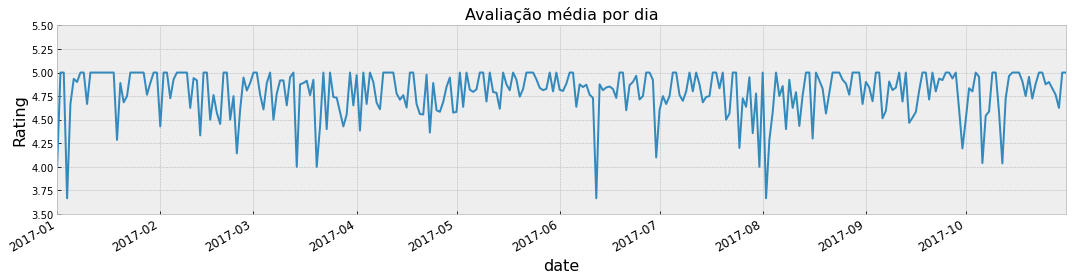

In [363]:
(respostas.groupby('date')['Rating'].mean()
 .plot(figsize=(15,4),
       ylim=(3.5,5.5), 
       title='Avaliação média por dia'), 
 plt.ylabel('Rating'),
 plt.tight_layout(),
 plt.savefig(IMAGES / 'av_dia.png')
);

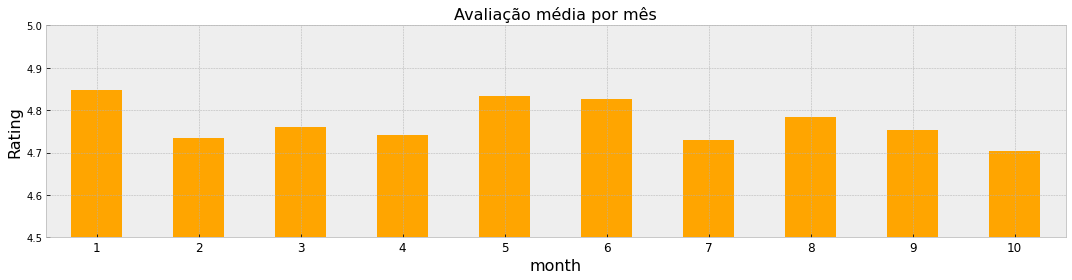

In [364]:
(respostas.groupby('month')['Rating'].mean()
 .plot.bar(figsize=(15,4),
           ylim=(4.5,5), 
           title='Avaliação média por mês', 
           color='orange'),
 plt.ylabel('Rating'),  
 plt.xticks(rotation=0), 
 plt.tight_layout(),
 plt.savefig(IMAGES / 'av_mes.png')
);

A média da avaliação diária varia bastante ao longo do período. Percebe-se, realmente, que no final de julho há uma queda um pouco mais agressiva em relação a períodos anteriores. Contudo, em fevereiro e março também observa-se vários picos de queda (não tão agressivos), assim como em meados de junho percebe-se uma pico de queda agressivo. 

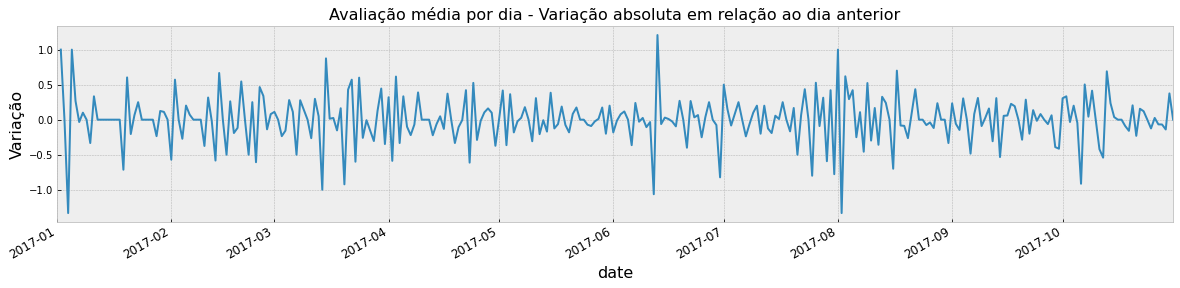

In [365]:
(respostas.groupby('date')['Rating'].mean()
 .diff()
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação absoluta em relação ao dia anterior'), 
 plt.ylabel('Variação')
);

Vemos uma certa agressividade maior na variação média diária no final de julho, mas há também similares oscilações em outros períodos.

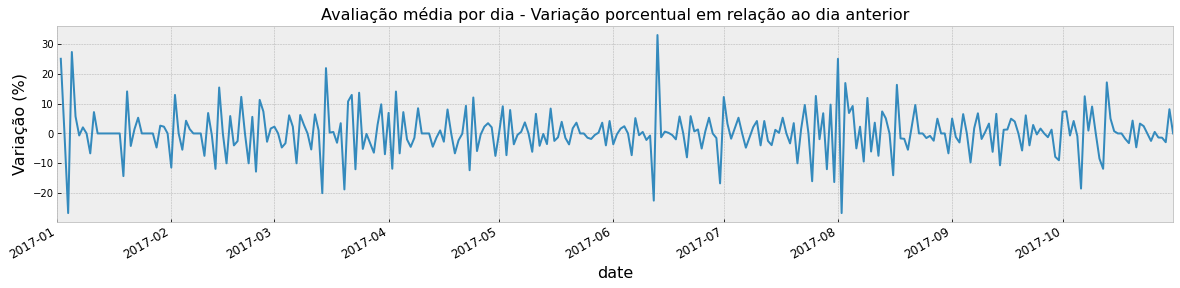

In [366]:
(respostas.groupby('date')['Rating'].mean()
 .pct_change()
 .multiply(100)
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação porcentual em relação ao dia anterior'), 
 plt.ylabel('Variação (%)')
);

Em termos percentuais, a oscilação diária em julho se aproximou de -18%, porém, esse comportamento também pode ser visto em outros períodos. O que mais uma vez demonstra que julho não foi mês atípico.

In [367]:
# Vamos olhar a dispersão dos dados ao longo dos dias
respostas.groupby('date')['Rating'].describe().T

date,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-14 00:00:00,2017-01-15 00:00:00,2017-01-16 00:00:00,2017-01-17 00:00:00,2017-01-18 00:00:00,2017-01-19 00:00:00,2017-01-20 00:00:00,2017-01-21 00:00:00,2017-01-22 00:00:00,2017-01-23 00:00:00,2017-01-24 00:00:00,2017-01-25 00:00:00,2017-01-26 00:00:00,2017-01-27 00:00:00,2017-01-28 00:00:00,2017-01-29 00:00:00,2017-01-30 00:00:00,2017-01-31 00:00:00,2017-02-01 00:00:00,2017-02-02 00:00:00,2017-02-03 00:00:00,2017-02-04 00:00:00,2017-02-05 00:00:00,2017-02-06 00:00:00,2017-02-07 00:00:00,2017-02-08 00:00:00,2017-02-09 00:00:00,2017-02-10 00:00:00,2017-02-11 00:00:00,2017-02-12 00:00:00,2017-02-13 00:00:00,2017-02-14 00:00:00,2017-02-15 00:00:00,2017-02-16 00:00:00,2017-02-17 00:00:00,2017-02-18 00:00:00,2017-02-19 00:00:00,2017-02-20 00:00:00,2017-02-21 00:00:00,2017-02-22 00:00:00,2017-02-23 00:00:00,2017-02-24 00:00:00,2017-02-25 00:00:00,2017-02-26 00:00:00,2017-02-27 00:00:00,2017-02-28 00:00:00,2017-03-01 00:00:00,2017-03-02 00:00:00,2017-03-03 00:00:00,2017-03-04 00:00:00,2017-03-05 00:00:00,2017-03-06 00:00:00,2017-03-07 00:00:00,2017-03-08 00:00:00,2017-03-09 00:00:00,2017-03-10 00:00:00,2017-03-11 00:00:00,2017-03-12 00:00:00,2017-03-13 00:00:00,2017-03-14 00:00:00,2017-03-15 00:00:00,2017-03-16 00:00:00,2017-03-17 00:00:00,2017-03-18 00:00:00,2017-03-19 00:00:00,2017-03-20 00:00:00,2017-03-21 00:00:00,2017-03-22 00:00:00,2017-03-23 00:00:00,2017-03-24 00:00:00,2017-03-25 00:00:00,2017-03-26 00:00:00,2017-03-28 00:00:00,2017-03-29 00:00:00,2017-03-30 00:00:00,2017-03-31 00:00:00,2017-04-01 00:00:00,2017-04-02 00:00:00,2017-04-03 00:00:00,2017-04-04 00:00:00,2017-04-05 00:00:00,2017-04-06 00:00:00,2017-04-07 00:00:00,2017-04-08 00:00:00,2017-04-09 00:00:00,2017-04-10 00:00:00,2017-04-11 00:00:00,2017-04-12 00:00:00,2017-04-13 00:00:00,2017-04-14 00:00:00,2017-04-15 00:00:00,2017-04-16 00:00:00,2017-04-17 00:00:00,2017-04-18 00:00:00,2017-04-19 00:00:00,2017-04-20 00:00:00,2017-04-21 00:00:00,2017-04-22 00:00:00,2017-04-23 00:00:00,2017-04-24 00:00:00,2017-04-25 00:00:00,2017-04-26 00:00:00,2017-04-27 00:00:00,2017-04-28 00:00:00,2017-04-29 00:00:00,2017-04-30 00:00:00,2017-05-01 00:00:00,2017-05-02 00:00:00,2017-05-03 00:00:00,2017-05-04 00:00:00,2017-05-05 00:00:00,2017-05-06 00:00:00,2017-05-07 00:00:00,2017-05-08 00:00:00,2017-05-09 00:00:00,2017-05-10 00:00:00,2017-05-11 00:00:00,2017-05-12 00:00:00,2017-05-13 00:00:00,2017-05-14 00:00:00,2017-05-15 00:00:00,2017-05-16 00:00:00,2017-05-17 00:00:00,2017-05-18 00:00:00,2017-05-19 00:00:00,2017-05-20 00:00:00,2017-05-21 00:00:00,2017-05-22 00:00:00,2017-05-23 00:00:00,2017-05-24 00:00:00,2017-05-25 00:00:00,2017-05-26 00:00:00,2017-05-27 00:00:00,2017-05-28 00:00:00,2017-05-29 00:00:00,2017-05-30 00:00:00,2017-05-31 00:00:00,2017-06-01 00:00:00,2017-06-02 00:00:00,2017-06-03 00:00:00,2017-06-04 00:00:00,2017-06-05 00:00:00,2017-06-06 00:00:00,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,2017-06-17 00:00:00,2017-06-18 00:00:00,2017-06-19 00:00:00,2017-06-20 00:00:00,2017-06-21 00:00:00,2017-06-22 00:00:00,2017-06-23 00:00:00,2017-06-24 00:00:00,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00,2017-07-05 00:00:00,2017-07-06 00:00:00,2017-07-07 00:00:00,2017-07-08 00:00:00,2017-07-09 00:00:00,2017-07-10 00:00:00,2017-07-11 00:00:00,2017-07-12 00:00:00,2017-07-13 00:00:00,2017-07-14 00:00:00,2017-07-15 00:00:00,2017-07-16 00:00:00,2017-07-17 00:00:00,2017-07-18 00:00:00,2017-07-19 00:00:00,2017-07-20 00:0

In [368]:
# Vamos olhar a dispersão dos dados ao longo dos meses
respostas.groupby('month')['Rating'].describe().T

month,1,2,3,4,5,6,7,8,9,10
count,216.000000,331.000000,384.000000,655.000000,613.000000,585.000000,372.000000,465.000000,655.000000,474.000000
mean,4.847222,4.734139,4.760417,4.741985,4.833605,4.825641,4.728495,4.784946,4.752672,4.702532
std,0.632302,0.853876,0.801367,0.836290,0.675224,0.714593,0.833235,0.774728,0.851274,0.913901
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Interessante notar que a quantidade diária de envio de avaliaçãoes oscila bastante. Além disso, em vários dias, o número de envios é bem baixo, o que pode acabar prejudicando  a qualidade da média. <p>
Outro ponto interessante: em praticamente todos os dias temos pelo menos uma avaliação 5.

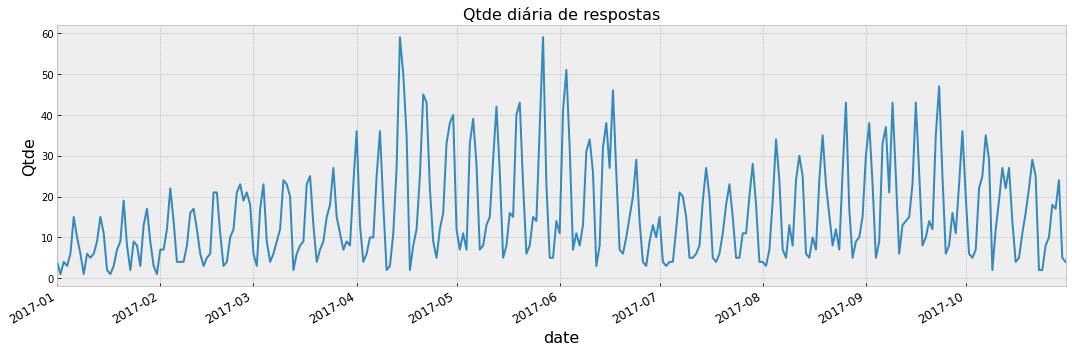

In [369]:
# Vamos ver a quantidade diária de envios de avaliações.
(respostas.groupby('date')['Rating']
 .count()
 .plot.line(figsize=(15,5),
            title='Qtde diária de respostas'),
 plt.ylabel('Qtde'),
 plt.tight_layout(), 
 plt.savefig(IMAGES / 'qtde_res_dia.png')
);

Conforme havia sido adiantado no case, o mês de julho apresenta menos envio de avaliações que os meses anteriores. Vamos ver como é o comportamento no mês fechado.

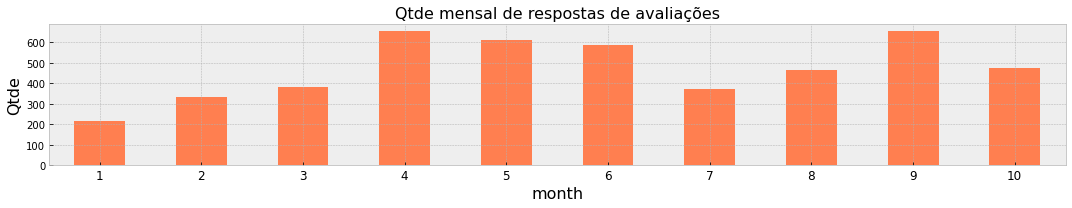

In [370]:
(respostas.groupby('month')['Rating']
 .count()
 .plot.bar(figsize=(15,3), color='coral',
            title='Qtde mensal de respostas de avaliações'),
 plt.ylabel('Qtde'),
 plt.xticks(rotation=0),
 plt.tight_layout(), 
 plt.savefig(IMAGES / 'qtde_res_mes.png')
);

Realmente em julho há uma significativa queda em relação aos 3 meses anteriores.

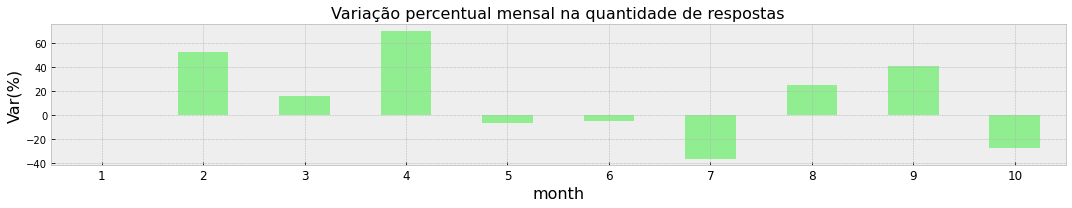

In [371]:
(respostas.groupby('month')['Rating']
 .count()
 .pct_change()
 .multiply(100)
 .plot.bar(figsize=(15,3), 
           color='lightgreen',
           title='Variação percentual mensal na quantidade de respostas'),
 plt.ylabel('Var(%)'), 
 plt.xticks(rotation=0),
 plt.tight_layout(), 
 plt.savefig(IMAGES / 'var_qtde_res_mes.png')
);

A queda no número de envio de avaliações foi em quase 40%. Vamos ver qual a quantidade mensal de envio de avaliações por nota (0-5).

In [372]:
respostas_por_mes_rating = respostas.pivot_table(index='Rating',
                                                      columns='month',
                                                      values='OrderID',
                                                      aggfunc='count')

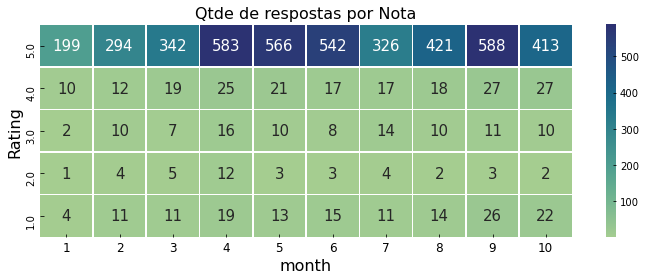

In [373]:
plt.figure(figsize=(10,4))
(sns.heatmap(respostas_por_mes_rating.sort_index(ascending=False), 
            annot=True, 
            fmt='d', 
            linewidths=0.5,
            cmap="crest",
            annot_kws={"fontsize":15}),
 plt.title('Qtde de respostas por Nota'), 
 plt.tight_layout(), 
 plt.savefig(IMAGES / 'res_por_nota.png')
);

Agora conseguimos olhar com mais clareza o que foi citado no case. Olhar apenas a média diária ou mensal pode "mascarar" o resultado inferior obtido no mês de julho. Acima, podemos notar uma queda de quase 40% no número de avaliações com nota 5. <p> 95% da queda total ocorrida entre o mês de junho e julho foi somente na avaliação 5 estrelas. <p>
**Contudo, não há aumento significativo nas avaliações 4, 3, 2 e 1. O que há é uma queda nas avaliações 5. Para termos mais segurança para dizer que os consumidores estão mais insatisfeitos, seria necessário haver um aumento das avaliações de faixas menores.**

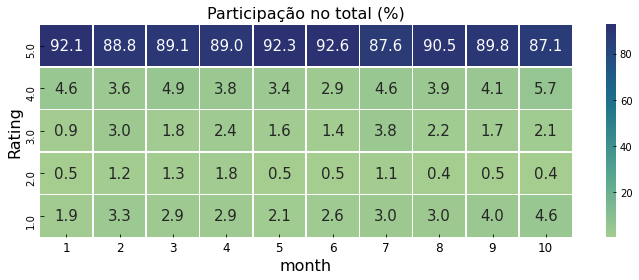

In [374]:
plt.figure(figsize=(10,4))
(sns.heatmap(
    (respostas.pivot_table(columns='Rating',
                          index='month',
                          values='OrderID',
                          aggfunc='count')
    .apply(lambda x: x/x.sum()*100, axis=1)
    .T)
    .sort_index(ascending=False),
    annot=True,
    fmt='.1f',
    linewidths=0.5, 
    cmap="crest", 
    annot_kws={"fontsize":15}),
 plt.title('Participação no total (%)'),
 plt.tight_layout(), 
 plt.savefig(IMAGES / 'par_por_nota.png')
);

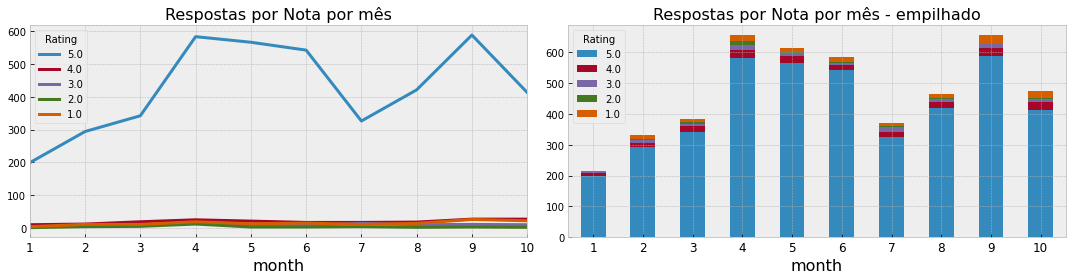

In [375]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
(respostas_por_mes_rating
 .sort_index(ascending=False)
 .T
 .plot.line(ax=ax1, title='Respostas por Nota por mês', linewidth=3)
)
(respostas_por_mes_rating
 .sort_index(ascending=False)
 .T
 .plot.bar(ax=ax2, title='Respostas por Nota por mês - empilhado', stacked=True), 
 plt.xticks(rotation=0)
), plt.tight_layout(), plt.savefig(IMAGES / 'av_por_nota.png');

Como pode ser observado, a quantidade de avaliações nota 5 caiu significativamente do mês de junho para o mês de julho. Os gráficos **parecem sugerir que não houve queda nas avaliações, houve queda nas avaliações de nota 5**, o que não necessariamente indica um aumento na insatisfação dos usuários/consumidores, já que não houve aumento no número das respostas 1, 2, 3 e 4. Vamos analisar mais um pouco.

Já que observamos um queda na quantidade de respostas em julho, sobretudo nas de nota 5, vamos olhar como foi a receita, número de pedidos e quantidade de clientes compradores, para veridicar se caem também.

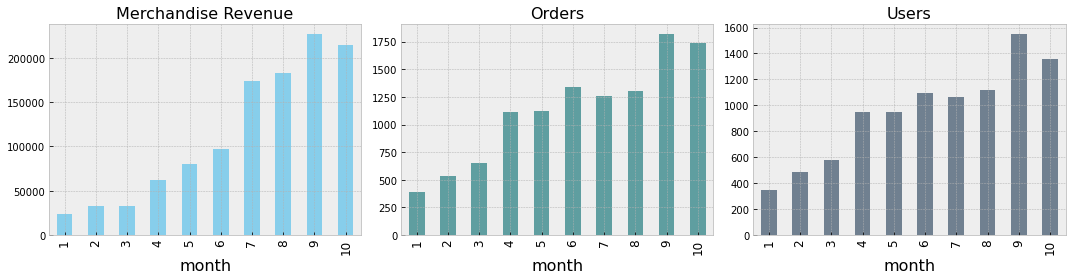

In [376]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
metricas = (Order_rating_DB
             .pivot_table(index='month',
                         values=['MerchandiseRevenue','OrderID','User'],
                         aggfunc={'MerchandiseRevenue': sum,
                                  'OrderID': 'count', 
                                  'User': pd.Series.nunique})
)
metricas['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue')
metricas['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders')
metricas['User'].plot.bar(ax=ax3, color='slategray', title='Users')
plt.tight_layout()
plt.savefig(IMAGES / 'rev_ord_users.png' );

No mês de julho, a receita apresenta um aumento, mas o número de pedidos e usuários cai. A queda no número de pedidos ou clientes, se fosse mais expressiva, poderia ser uma das razões da queda das avaliações de nota 5. Contudo, não parece ser este o caso. Vamos olhar a quantidade de clientes distintos que avaliaram os pedidos ao longo dos meses.

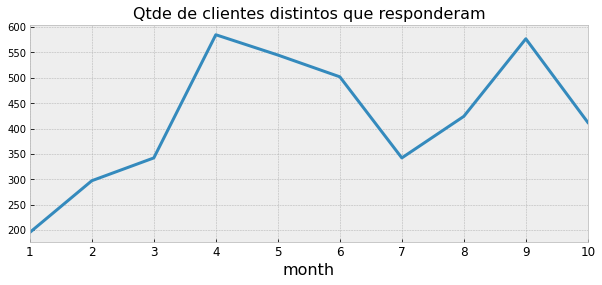

In [377]:
(respostas
 .groupby('month')['User']
 .nunique()
 .plot(title="Qtde de clientes distintos que responderam", figsize=(10,4), linewidth=3)
);

Cai também! <p>
Vamos ver a métrica de receita por cliente.

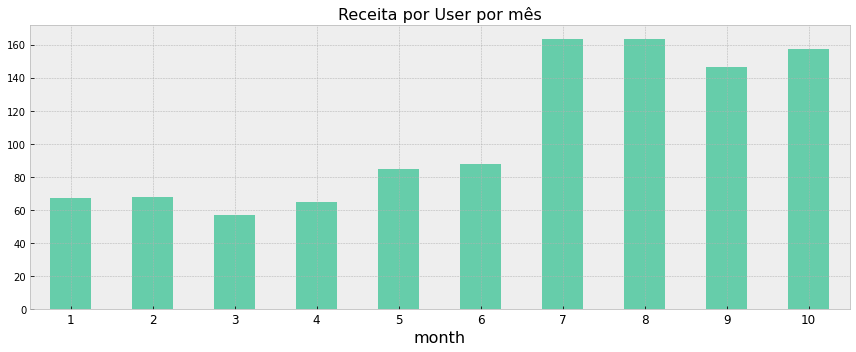

In [378]:
c_distintos = (Order_rating_DB
                 .groupby('month')['User']
                 .nunique()
)
q_orders = (Order_rating_DB
                 .groupby('month')['MerchandiseRevenue']
                 .sum()
)
(
 (q_orders / c_distintos)
    .plot.bar(title="Receita por User por mês", 
              color='mediumaquamarine', 
              figsize=(12,5)),
    plt.xticks(rotation=0), 
    plt.tight_layout(), 
    plt.savefig(IMAGES / 'rec_por_user.png')
);

Vemos que há uma queda no número de pedidos por cliente do mês de junho para o mês de julho. Tanto número de pedido como número de user caiu, mas a queda de pedidos foi proporcionalmente maior que a queda de clientes. Será um fator sazonal?<p>

#### Cliente que concentra parte da receita
Durante a análise, percebi que um cliente passa a ter relevância após julho, concentrando significativa parte da receita.

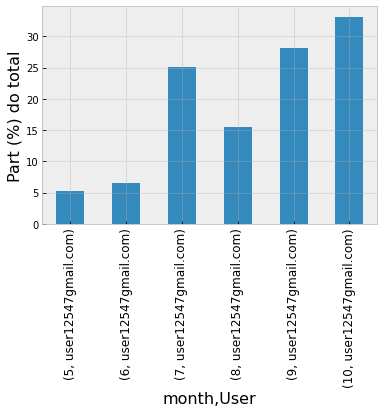

In [379]:
user12547 = Order_rating_DB.groupby(['month','User'])['MerchandiseRevenue'].sum()
user12547 = user12547.groupby(level=0).apply(lambda x: x/x.sum()*100)
user12547[user12547.index.isin(['user12547gmail.com'], level=1)].plot.bar()
plt.ylabel('Part (%) do total');

#### Será que o período do dia em que o pedido é feito, influencia na quantidade de respostas ou na nota?

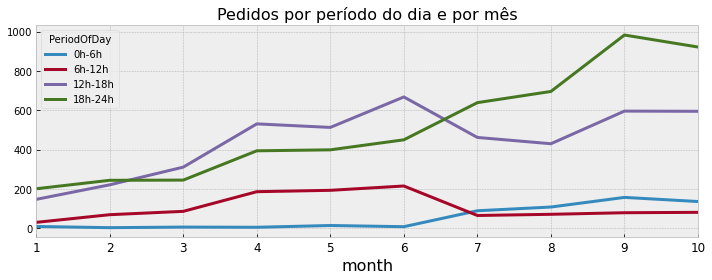

In [380]:
(Order_rating_DB
 .pivot_table(index='month',
              columns='PeriodOfDay',
              values='OrderID',
              aggfunc='count')
).plot(title='Pedidos por período do dia e por mês', 
       linewidth=3, 
       figsize=(10,4))
plt.tight_layout()
plt.savefig(IMAGES / 'ped_dia_mes.png');

Interessante notar uma queda número de pedidos do período "12-18" a partir do mês de julho. Os pedidos do período das "18-24" que vinha crescendo até junho, cresce ainda mais a patir de julho. <p> 
Vamos ver como é a avaliação média em cada período e em seguida abrir a quantidade de avaliações por nota e período.

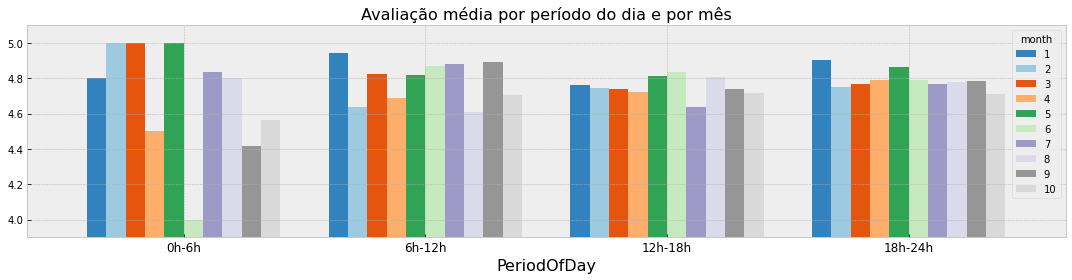

In [381]:
(respostas
 .pivot_table(columns='month',
              index='PeriodOfDay',
              values='Rating',
              aggfunc='mean')
).plot.bar(title='Avaliação média por período do dia e por mês',
           figsize=(15,4),
           ylim=(3.9, 5.1), 
           width=0.8, 
           colormap='tab20c')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(IMAGES / 'av_por_periodo.png');

É possível observar que a queda na avaliação média ocorrida no mês de julho ocorre principalmente no período das 12h às 18hs. Vamos explorar isso mais um pouco.

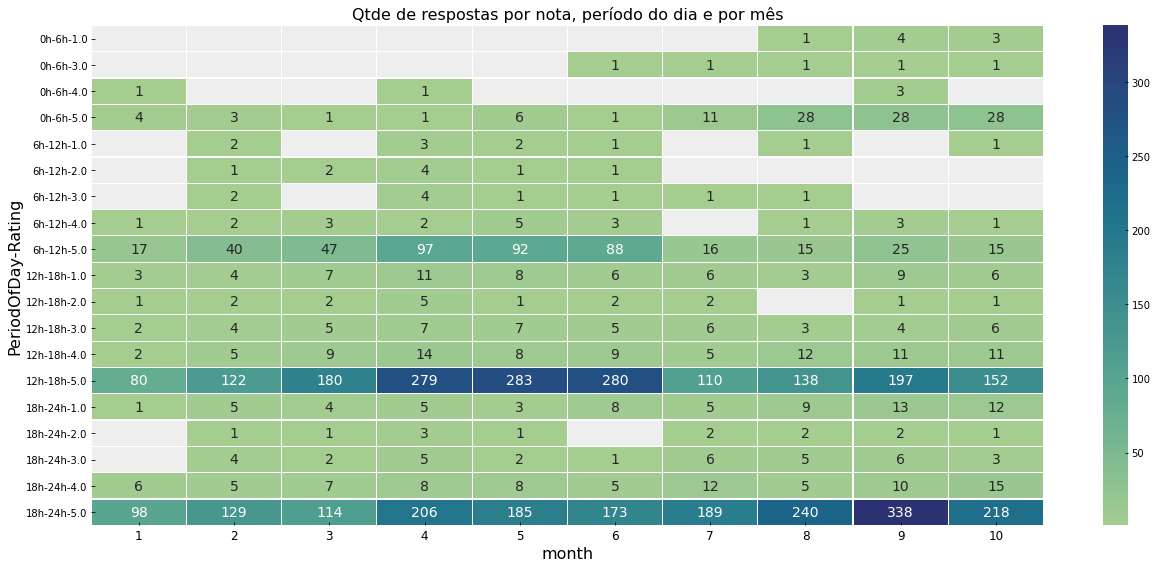

In [382]:
plt.figure(figsize=(18,8))
(sns.heatmap(
    (respostas
     .pivot_table(columns='month',
                  index=['PeriodOfDay','Rating'],
                  values='OrderID',
                  aggfunc='count')), 
    annot=True, 
    fmt='.0f', 
    linewidths=0.2,
    cmap="crest",
    annot_kws={"fontsize":14})
)
plt.title("Qtde de respostas por nota, período do dia e por mês")
plt.tight_layout();

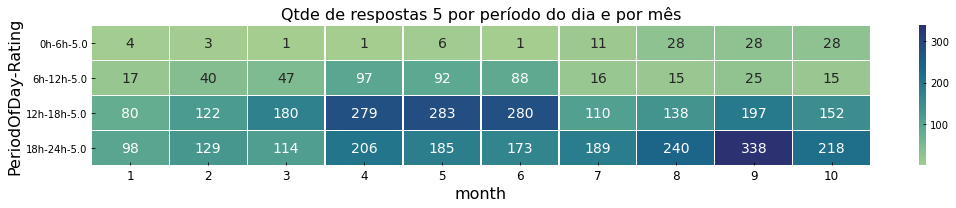

In [383]:
plt.figure(figsize=(15,3))
(sns.heatmap(
    (respostas.query("Rating == 5")
     .pivot_table(columns='month',
                  index=['PeriodOfDay','Rating'],
                  values='OrderID',
                  aggfunc='count')),  
    annot=True,
    fmt='.0f', 
    linewidths=0.2,
    cmap="crest", 
    annot_kws={"fontsize":14})
)
plt.title("Qtde de respostas 5 por período do dia e por mês")
plt.tight_layout()
plt.savefig(IMAGES / 'resp_nota_5_period.png');

Vê-se que a maior queda no número de avaliações 5 estrelas ocorre no período "12-18". Esta queda de cerca de 170 avaliações (280-110) representa quase 80% da queda total de avaliações 5 estrelas.  Em seguida, o período 6h-12h também apresenta queda <p>
O que está acontecendo com este período? Estamos perdendo vendas? Pedidos? Clientes? Havíamos observado que este período do dia teve redução de pedidos nos meses julho e agosto, vamos aprofunda mais um pouco.

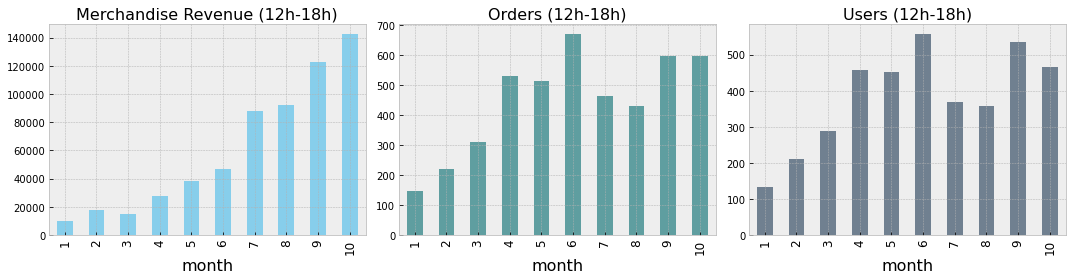

In [384]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

metrics2 = (Order_rating_DB.query("PeriodOfDay == '12h-18h'")
     .pivot_table(index='month',
                 values=['MerchandiseRevenue','OrderID','User'],
                 aggfunc={'MerchandiseRevenue': sum,
                          'OrderID': 'count', 
                          'User': pd.Series.nunique})
)
metrics2['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue (12h-18h)')
metrics2['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders (12h-18h)')
metrics2['User'].plot.bar(ax=ax3, color='slategray', title='Users (12h-18h)')
plt.tight_layout()
plt.savefig(IMAGES / 'rev_ord_users_12_18.png' );

Vemos que neste período do dia (12h-18h), temos uma redução de clientes e de pedidos, apesar da receita não estar caindo. Isso nos leva a verificar como está a receita por pedido e a receita por cliente.

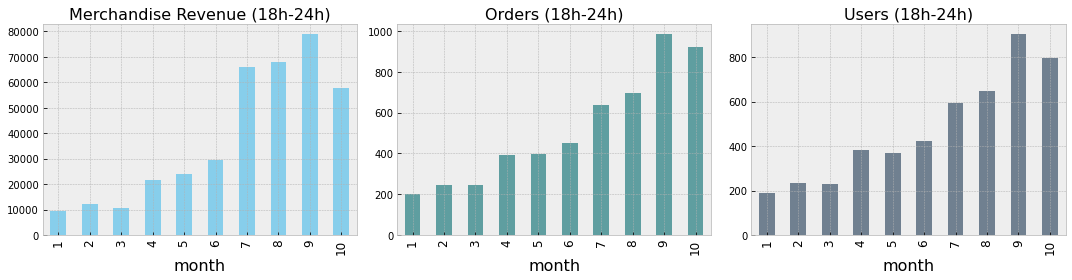

In [385]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

metrics3 = (Order_rating_DB.query("PeriodOfDay == '18h-24h'")
     .pivot_table(index='month',
                 values=['MerchandiseRevenue','OrderID','User'],
                 aggfunc={'MerchandiseRevenue': sum,
                          'OrderID': 'count', 
                          'User': pd.Series.nunique})
)
metrics3['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue (18h-24h)')
metrics3['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders (18h-24h)')
metrics3['User'].plot.bar(ax=ax3, color='slategray', title='Users (18h-24h)')
plt.tight_layout();

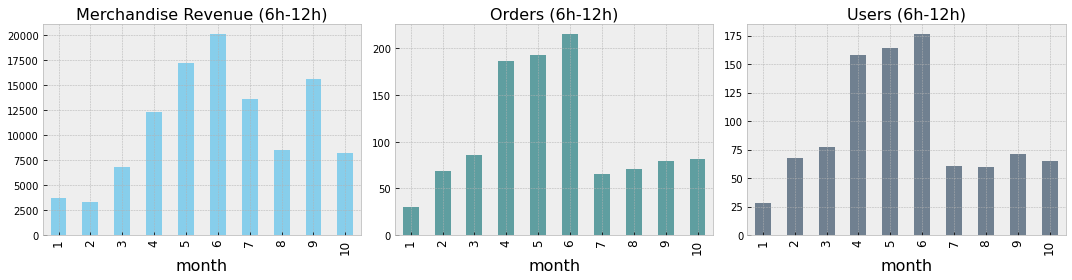

In [386]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

metrics4 = (Order_rating_DB.query("PeriodOfDay == '6h-12h'")
     .pivot_table(index='month',
                 values=['MerchandiseRevenue','OrderID','User'],
                 aggfunc={'MerchandiseRevenue': sum,
                          'OrderID': 'count', 
                          'User': pd.Series.nunique})
)
metrics4['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue (6h-12h)')
metrics4['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders (6h-12h)')
metrics4['User'].plot.bar(ax=ax3, color='slategray', title='Users (6h-12h)')
plt.tight_layout()
plt.savefig(IMAGES / 'rev_ord_users_6_12.png');

Neste período, a queda parece ser ainda mais severa e persistente. Tanto receita como pedidos e users caem após o mês de junho.

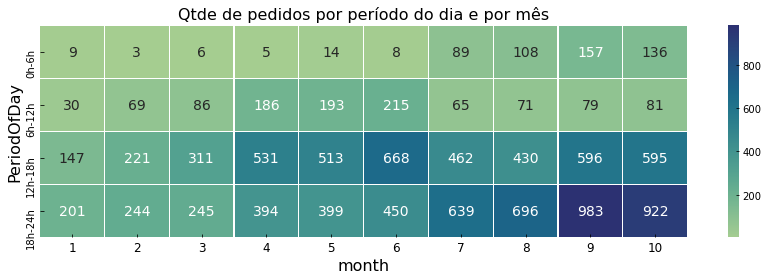

In [387]:
plt.figure(figsize=(12,4))
(sns.heatmap(
    (Order_rating_DB
     .pivot_table(columns='month',
                  index=['PeriodOfDay'],
                  values='OrderID',
                  aggfunc='count')
    ),  annot=True, 
    fmt='.0f',
    linewidths=0.2, 
    cmap="crest",
    annot_kws={"fontsize":14})
)
plt.title("Qtde de pedidos por período do dia e por mês")
plt.tight_layout();

Aparentemente, o investimento na campanha está surtindo efeito mais no período "18-24", onde a avaliação permanece estável. Esse período vem apresentando aumento de pedidos e clientes.

### O que acontece com a avaliação se removermos o período diurno (6h-18h) dos dados?

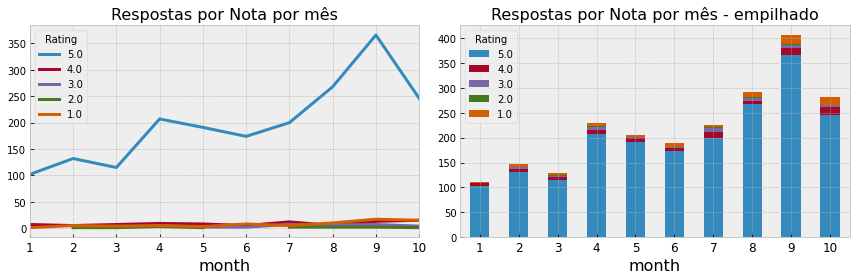

In [388]:
respostas_por_mes_rating_sem_12_18 = (respostas
                                     .query("PeriodOfDay != '6h-12h' and PeriodOfDay != '12h-18h'")
                                     .pivot_table(index='Rating',
                                                  columns='month',
                                                  values='OrderID',
                                                  aggfunc='count')
                                    )
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
(respostas_por_mes_rating_sem_12_18
 .sort_index(ascending=False)
 .T
 .plot.line(ax=ax1, title='Respostas por Nota por mês', linewidth=3)
)
(respostas_por_mes_rating_sem_12_18
 .sort_index(ascending=False)
 .T
 .plot.bar(ax=ax2, title='Respostas por Nota por mês - empilhado', stacked=True), 
 plt.xticks(rotation=0)
)
plt.tight_layout()
plt.savefig(IMAGES / 'av_por_nota_noturno.png');

Os dados passam a mostrar um cenário totalmente diferente.

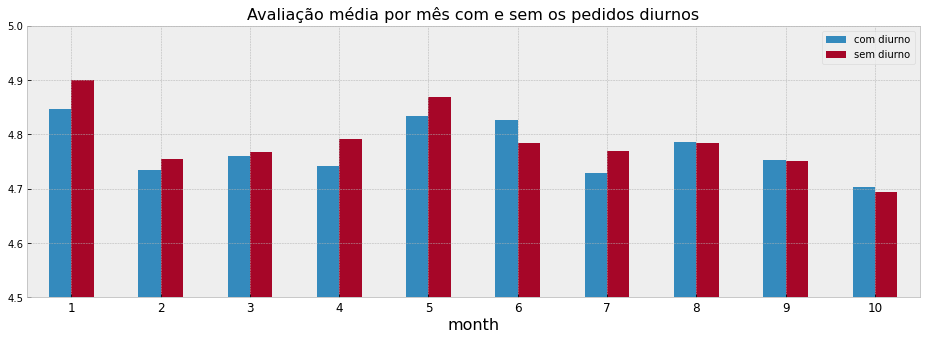

In [389]:
pd.DataFrame(
    {'com diurno': respostas.groupby('month')['Rating'].mean(),
     'sem diurno': (respostas .query("PeriodOfDay != '6h-12h' and PeriodOfDay != '12h-18h'").groupby('month')['Rating'].mean())}
).plot.bar(ylim=(4.5,5), 
           figsize=(16,5),
           title="Avaliação média por mês com e sem os pedidos diurnos"
          )
plt.xticks(rotation=0);

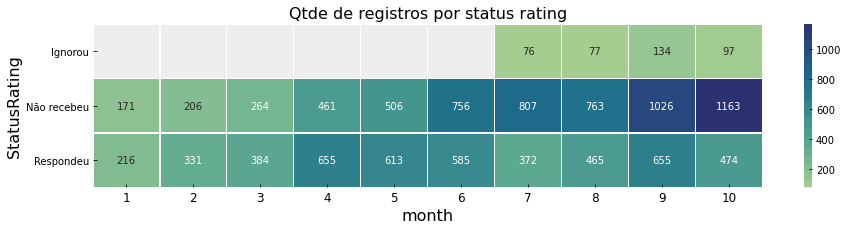

In [390]:
# Vamos  observar a quantidade de registros por status rating
Order_rating_DB['StatusRating'] = (
    Order_rating_DB['Rating'].apply(lambda x: 'Ignorou' if x==-1.0 else 'Não recebeu' if pd.isna(x)==True or x==0 else "Respondeu")
)
plt.figure(figsize=(15,3))
registros_por_status_rating = Order_rating_DB.pivot_table(
                                index='StatusRating',
                                columns='month',
                                values='OrderID',
                                aggfunc='count')
(sns.heatmap(
    registros_por_status_rating,
    annot=True, 
    fmt='.0f',
    linewidths=0.5, 
    cmap="crest")
)
plt.title('Qtde de registros por status rating');

Porque antes do mes de julho não há casos "ignorou"?

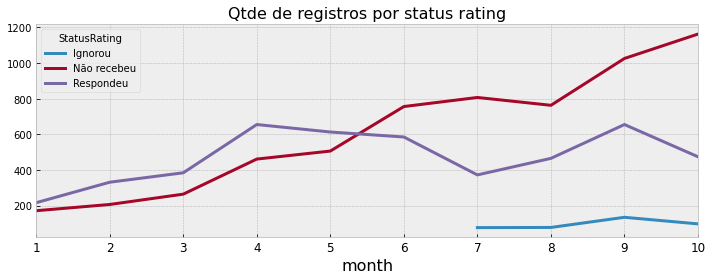

In [391]:
(registros_por_status_rating
 .T
 .plot(title='Qtde de registros por status rating',
       linewidth=3,
       figsize=(10,4))
)
plt.tight_layout()
plt.savefig(IMAGES / 'reg_por_nota.png');

O número de clientes sem receber a avaliação cresceu muito ao longo do ano, ao passo que o número de clientes que recebeu o e-mail para avaliação cai bastante em Julho. Isso sugere que precisamos enviar os e-mails solicitando a avaliação. A ausencia das avaliações tende a penalizar mais a nota 5, já que ele representa cerca de 90% do total das avaliações. <p> 
**Hipótese:** Será que os clientes que não receberam são, em sua maioria, os clientes que antes davam nota 5?

#### Como é o comportamento das avaliações entre os estados.

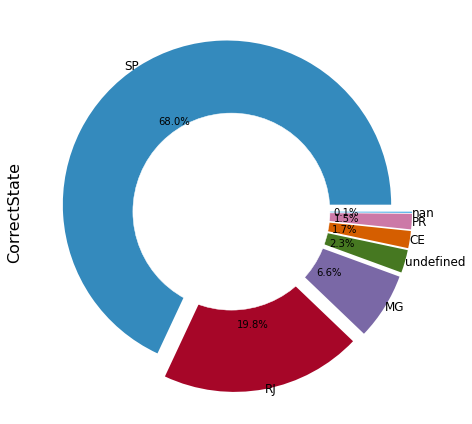

In [392]:
graf_rosca = plt.Circle((0, 0), 0.6, color='white')
(respostas['CorrectState']
 .value_counts(normalize=True, dropna=False)
 .plot
 .pie(figsize=(8,6), 
      autopct='%1.1f%%', 
      explode=(0.05,0.1,0.1,0.1,0.1,0.1,0.1),
      labeldistance=1
      )
);
plt.gca().add_artist(graf_rosca)
plt.tight_layout()

Quase 70% das avaliações vieram de SP. Vamos olhar o comportamento das avaliações ao longo do ano por estado para ver se a queda no mês sete ficou concentrada. 

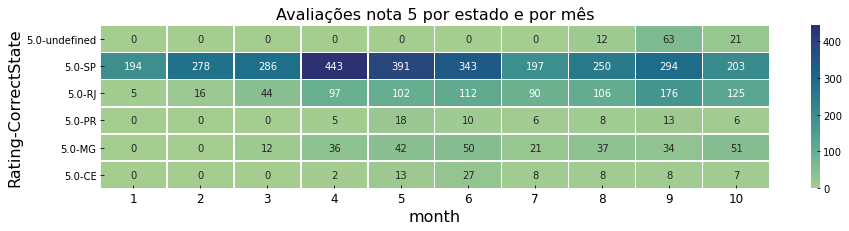

In [393]:
plt.figure(figsize=(15,3))
(sns.heatmap(
    (respostas
     .query("Rating == 5")
     .pivot_table(index=['Rating','CorrectState'],
                  columns='month',
                  values='OrderID',
                  aggfunc='count',
                 dropna=False)
     .sort_index(ascending=False)
     .fillna(0)
     .astype(int)
    ),
    annot=True, 
    fmt='.0f',
    linewidths=0.5,
    cmap="crest")
)
plt.title('Avaliações nota 5 por estado e por mês');

A queda no número de avaliações com nota 5 não cai apenas em SP, mas nos demais estados também. <p>
Já vimos anteriormente que a queda no número de envios do e-mail para avaliação cai no mês de julho. Isso posso indicar que a queda nas avaliações de nota 5 pode estar relacionada a queda nos envios destes e-mails. Os clientes não estão recebendo o e-mail para então poder avaliar com nota 5.

#### Como é  avaliação média para quem compra uma vez em relação a quem compra mais de uma vez? 
Avaliação por pedido, não por mes.

In [394]:
# Adicionar colunas
Order_rating_DB['QtdeCompras'] =  (Order_rating_DB
                                   .sort_values(['User','Date&Time'])
                                   .groupby(['User'])['User']
                                   .cumcount() + 1)
bins = [0,1,2,100]
labels = ['1x', '2x', '3x ou mais']
Order_rating_DB['QtdeComprasLabel'] = pd.cut(Order_rating_DB['QtdeCompras'], bins=bins, labels=labels)

filtro = [-1,0,np.nan]
respostas2 = Order_rating_DB[~Order_rating_DB['Rating'].isin(filtro)].copy()
respostas2.head(5)

,OrderID,OrderNumber,Week,Date&Time,Comment,User,MerchandiseRevenue,PaymentMethod,POCID,Rating,Reasons,ShippingType,State,CorrectWeek,CorrectState,date,hour,day,month,month-day,PeriodOfDay,StatusRating,QtdeCompras,QtdeComprasLabel,DayOfWeek
0,191357,14027,1,2017-01-01 10:11:01,NaN,user7gmail.com,105.120,NaN,26,5.0,NaN,receber,SP,52,SP,2017-01-01,10,1,1,0101,6h-12h,Respondeu,1,1x,7 Domingo
1,191361,14031,1,2017-01-01 11:39:28,NaN,user11gmail.com,70.848,NaN,30,5.0,NaN,receber,SP,52,SP,2017-01-01,11,1,1,0101,6h-12h,Respondeu,1,1x,7 Domingo
3,191384,14054,1,2017-01-01 15:35:10,NaN,user33gmail.com,48.816,NaN,29,1.0,NaN,receber,SP,52,SP,2017-01-01,15,1,1,0101,12h-18h,Respondeu,1,1x,7 Domingo
4,191385,14055,1,2017-01-01 16:02:38,NaN,user34gmail.com,70.848,NaN,30,5.0,NaN,receber,SP,52,SP,2017-01-01,16,1,1,0101,12h-18h,Respondeu,1,1x,7 Domingo
8,191414,14084,2,2017-01-02 18:24:46,NaN,user61gmail.com,81.456,NaN,21,5.0,NaN,receber,SP,1,SP,2017-01-02,18,2,1,0102,18h-24h,Respondeu,1,1x,1 Segunda


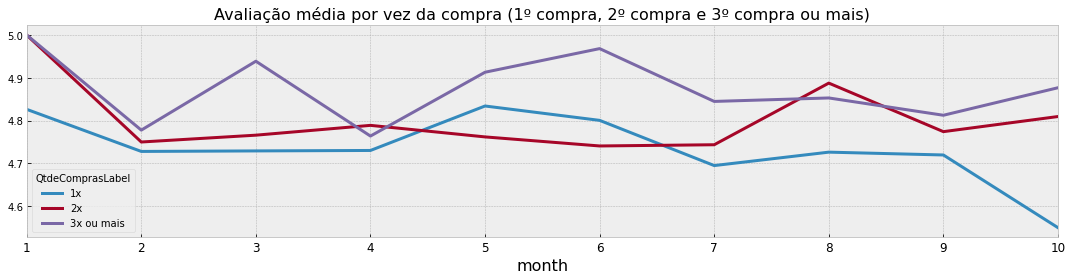

In [633]:
(respostas2.pivot_table(
    index='month',
    columns='QtdeComprasLabel',
    values='Rating',
    aggfunc='mean'
    )
).plot(figsize=(15,4),
      title='Avaliação média por vez da compra (1º compra, 2º compra e 3º compra ou mais)',
      linewidth=3)
plt.tight_layout()
plt.savefig(IMAGES / 'av_vez_da_compra.png')

Os clientes que estão na terceira compra (ou maior) avaliam melhor do que aqueles que estão na primera ou segunda compra.

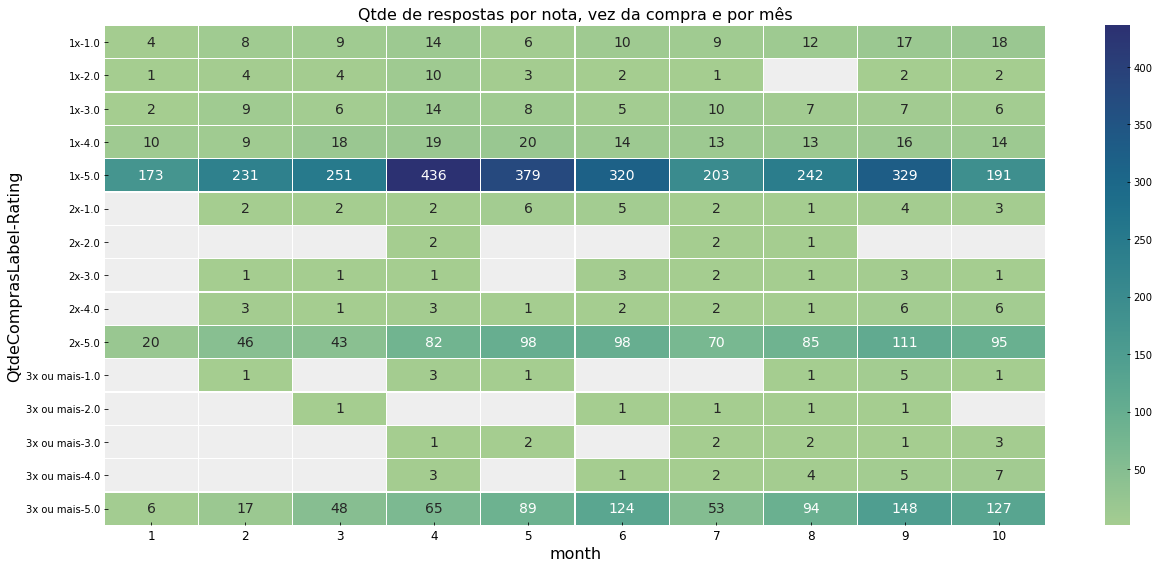

In [396]:
plt.figure(figsize=(18,8))
(sns.heatmap(
    (respostas2
     .pivot_table(columns='month',
                  index=['QtdeComprasLabel','Rating'],
                  values='OrderID',
                  aggfunc='count')),  
    annot=True, 
    fmt='.0f',
    linewidths=0.2, 
    cmap="crest",
    annot_kws={"fontsize":14})
)
plt.title("Qtde de respostas por nota, vez da compra e por mês")
plt.tight_layout();

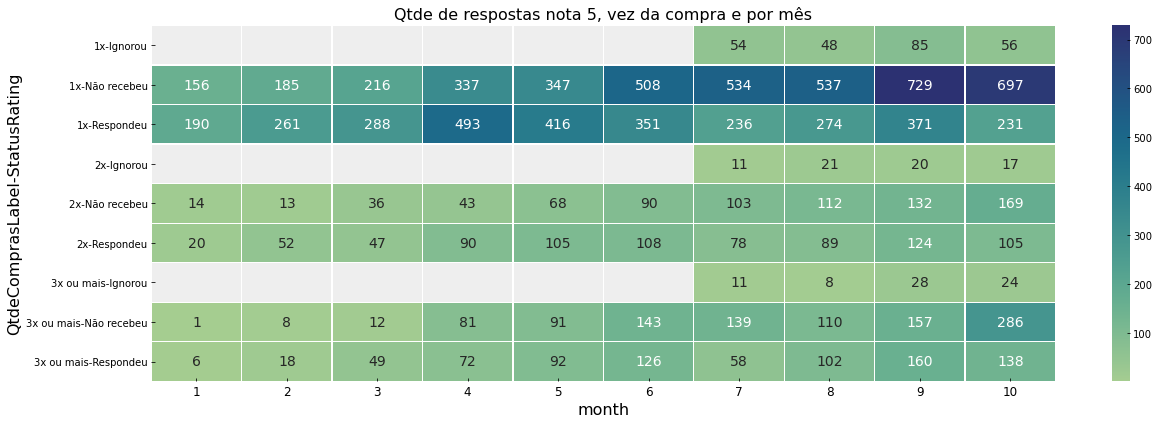

In [397]:
plt.figure(figsize=(18,6))
(sns.heatmap(
    (Order_rating_DB
     .pivot_table(columns='month',
                  index=['QtdeComprasLabel','StatusRating'],
                  values='OrderID',
                  aggfunc='count')
    ),
    annot=True,
    fmt='.0f', 
    linewidths=0.2,
    cmap="crest",
    annot_kws={"fontsize":14})
)
plt.title("Qtde de respostas nota 5, vez da compra e por mês")
plt.tight_layout();

A taxa de resposta ( ignorou / (ignorou + respondeu) ) é melhor, a medida que o número de compras aumenta (quando mais o cliente compra, mas ele responde).

#### Vamos analisar apenas os casos em que houve avaliação do cliente, mas apenas de 1 a 4 estrelas.
No case, parece haver a precisa de que uma avaliação ruim é a que vai de 1 a 4 estrelas.

In [398]:
bad_rating = respostas.query("Rating < 5").copy()

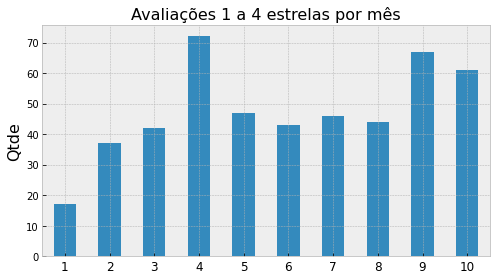

In [631]:
(bad_rating['month']
 .value_counts()
 .sort_index()
).plot.bar(title="Avaliações 1 a 4 estrelas por mês", figsize=(7,4))
plt.ylabel('Qtde')
plt.xticks(rotation=0)
plt.tight_layout(), plt.savefig(IMAGES / 'av_1_a_4.png');

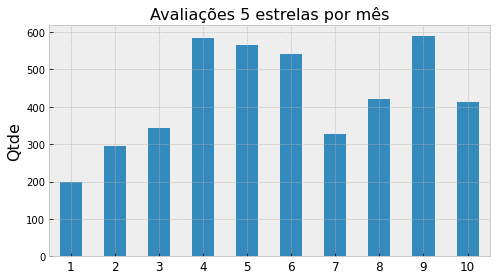

In [632]:
(respostas.query("Rating == 5")['month']
 .value_counts()
 .sort_index()
).plot.bar(title="Avaliações 5 estrelas por mês", figsize=(7,4))
plt.ylabel('Qtde')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(IMAGES / 'av_5.png')

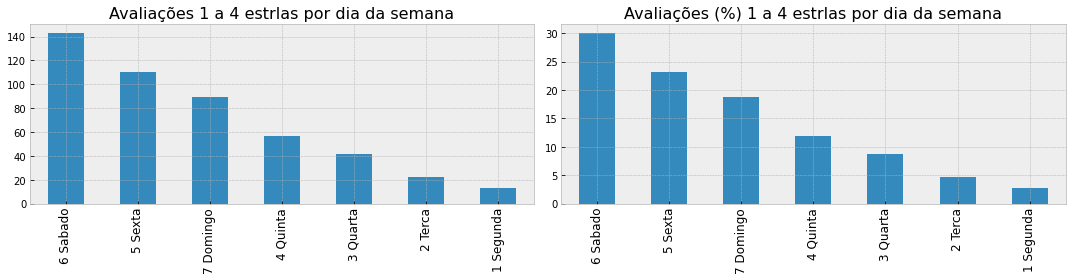

In [562]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))

(bad_rating['DayOfWeek'].value_counts()
 .plot.bar(ax=ax1, title='Avaliações 1 a 4 estrlas por dia da semana')
)
(bad_rating['DayOfWeek']
 .value_counts(normalize=True)
 .multiply(100)
 .plot.bar(ax=ax2, title='Avaliações (%) 1 a 4 estrlas por dia da semana')
)
plt.tight_layout()
plt.savefig(IMAGES / 'av_1_a_4_diasemana.png');

Sexta e sábado concentram quase 55% das avaliações 1 a 4 estrelas. Vamos ver como é essa evolução ao longo dos meses.

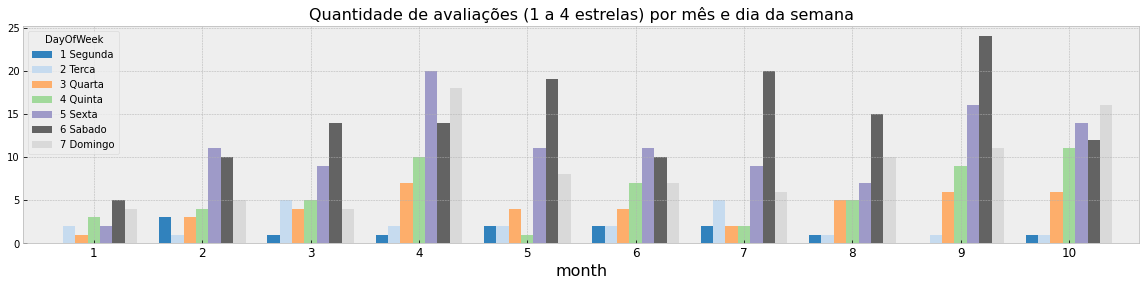

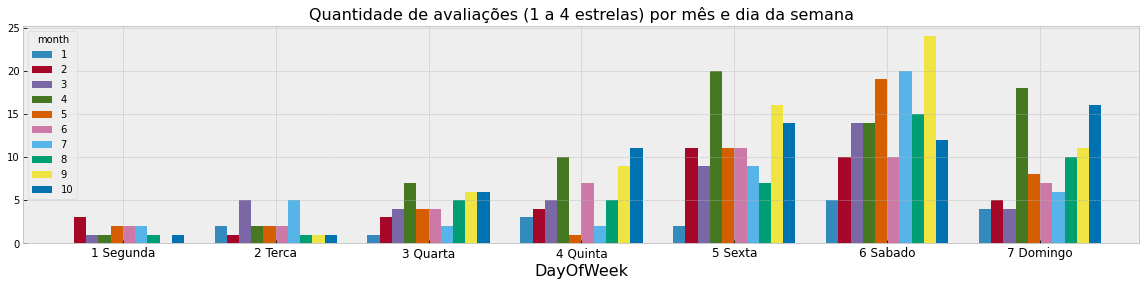

In [401]:
(bad_rating
 .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count') 
).plot.bar(figsize=(20,4), width=0.8,  colormap='tab20c', title='Quantidade de avaliações (1 a 4 estrelas) por mês e dia da semana')
plt.xticks(rotation=0)
(bad_rating
 .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count')
 .T
).plot.bar(figsize=(20,4), width=0.8,  title='Quantidade de avaliações (1 a 4 estrelas) por mês e dia da semana')
plt.xticks(rotation=0);

Na sexta e no sábado o volume de reclamações de uma maneira geral é maior. Não é algo que passou a acontecer após os investimentos, já era o comportamento anterior. 
Vamos ver se as reclamações do tipo "mais de 1 hora" e "cerveja quente" (que aumentaram bastante em setembro e outrubro) tem comportamento semelhante.

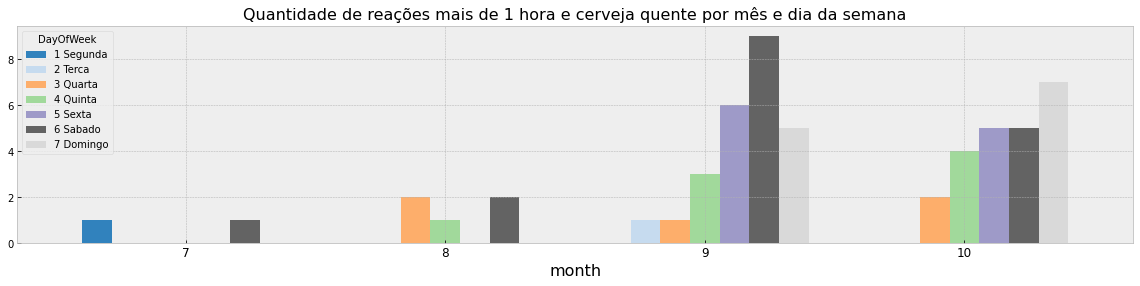

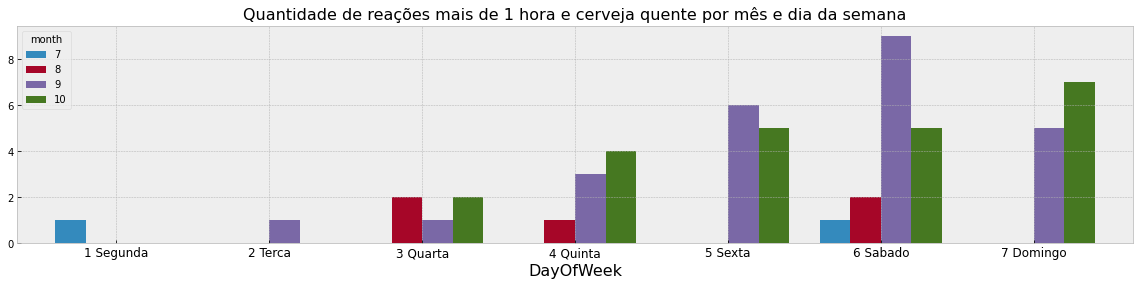

In [402]:
filtro = Bad_rating_reasons.query("rating_reasons == 'mais de 1 hora' or rating_reasons == 'cerveja quente'")['Order Number']

(bad_rating[bad_rating['OrderNumber'].isin(filtro)]
 .pivot_table(index=['month'],columns=['DayOfWeek'], values='OrderID', aggfunc='count') 
).plot.bar(figsize=(20,4), width=0.8,  colormap='tab20c', title='Quantidade de reações mais de 1 hora e cerveja quente por mês e dia da semana')
plt.xticks(rotation=0)

(bad_rating[bad_rating['OrderNumber'].isin(filtro)]
 .pivot_table(index=['month'],columns=['DayOfWeek'], values='OrderID', aggfunc='count').T
).plot.bar(figsize=(20,4), width=0.8, title='Quantidade de reações mais de 1 hora e cerveja quente por mês e dia da semana')
plt.xticks(rotation=0);

Esse tipo de reclamação também é maior às sextas e sábados. <p>
    
Agora, vamos ver o volume de pedidos por dia da semana e ver se:
    
    - Também há mais pedidos nos finais de semana
    - Se sempre foi assim ou passou a ser após os investimentos
    

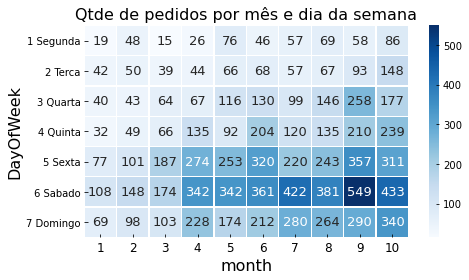

In [634]:
plt.figure(figsize=(7,4))
sns.heatmap(
    (Order_rating_DB
     .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count') .T
    ),
    annot=True, 
    fmt='.0f',
    linewidths=0.2, 
    annot_kws={"fontsize":13},
    cmap='Blues'
)
plt.title('Qtde de pedidos por mês e dia da semana')
plt.tight_layout()
plt.savefig(IMAGES / 'ped_mes_diasemana.png')

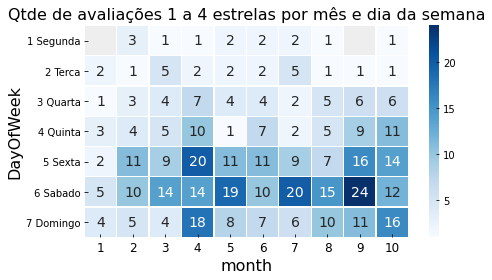

In [635]:
plt.figure(figsize=(7,4))
sns.heatmap(
    (bad_rating
     .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count') .T
    ),
    annot=True, 
    fmt='.0f',
    linewidths=0.2, 
    annot_kws={"fontsize":14},
    cmap='Blues'
)
plt.title('Qtde de avaliações 1 a 4 estrelas por mês e dia da semana')
plt.tight_layout()
plt.savefig(IMAGES / 'av_1_a_4_mes_diasemana.png');

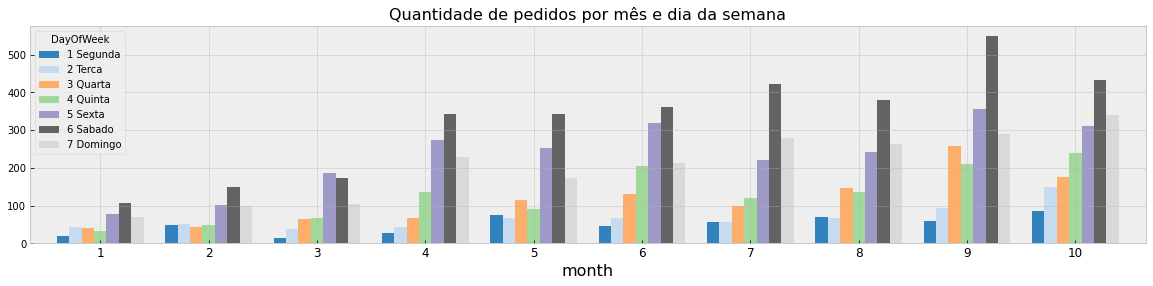

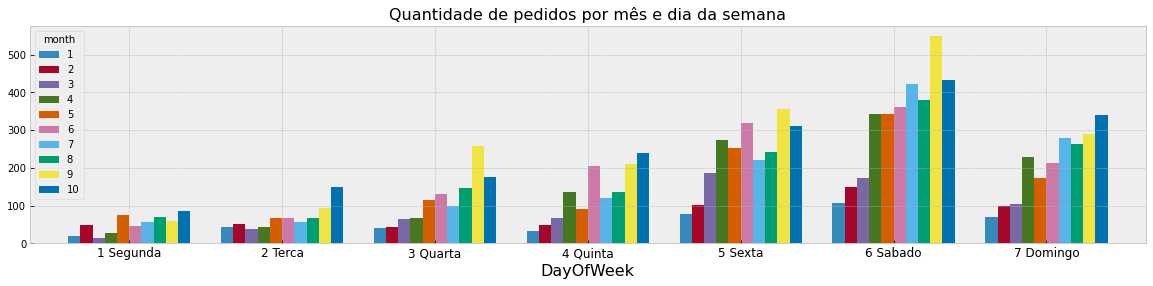

In [403]:
(Order_rating_DB
 .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count') 
).plot.bar(figsize=(20,4), width=0.8,  colormap='tab20c', title='Quantidade de pedidos por mês e dia da semana')
plt.xticks(rotation=0)

(Order_rating_DB
 .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count')
 .T
).plot.bar(figsize=(20,4), width=0.8, title='Quantidade de pedidos por mês e dia da semana')
plt.xticks(rotation=0);

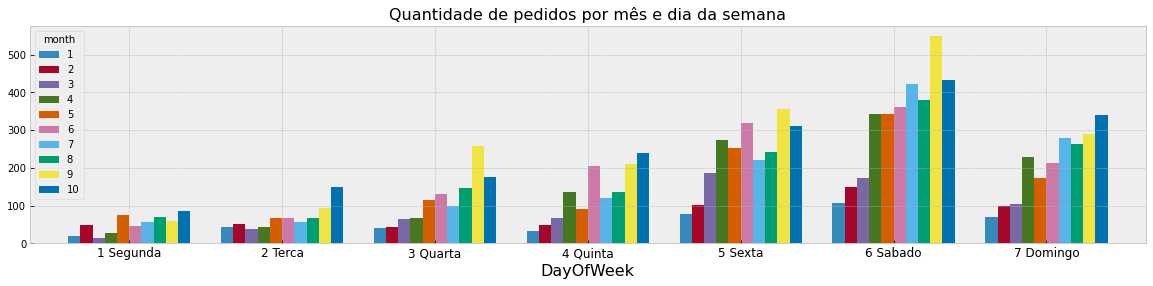

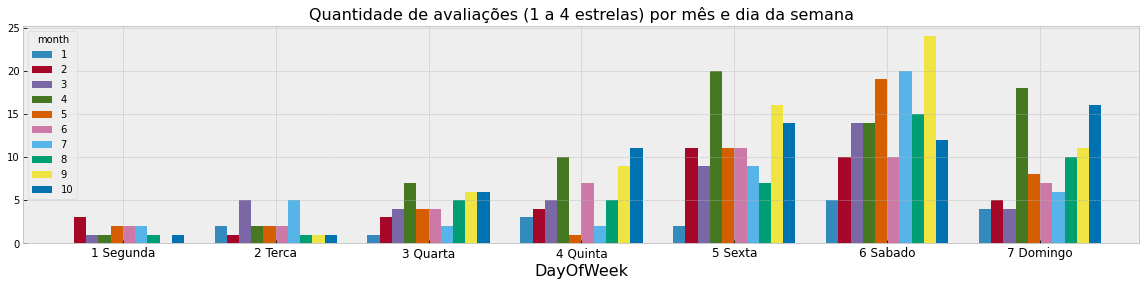

In [404]:
(Order_rating_DB
 .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count')
 .T
).plot.bar(figsize=(20,4), width=0.8, title='Quantidade de pedidos por mês e dia da semana')
plt.xticks(rotation=0);
(bad_rating
 .pivot_table(index=['month'], columns=['DayOfWeek'], values='OrderID', aggfunc='count')
 .T
).plot.bar(figsize=(20,4), width=0.8,  title='Quantidade de avaliações (1 a 4 estrelas) por mês e dia da semana')
plt.xticks(rotation=0);

Aparentemente, a quantidade de avaliações 1 a 4 estrelas acompanha o volume de pedidos como um todo, ou seja, aumenta às sextas, sábados e domingos. Segunda e terça ela se apresenta mais baixa.
Vamos gerar uma taxa para cada avaliação, ou seja, quantidade de avaliações x quantidade de pedidos.

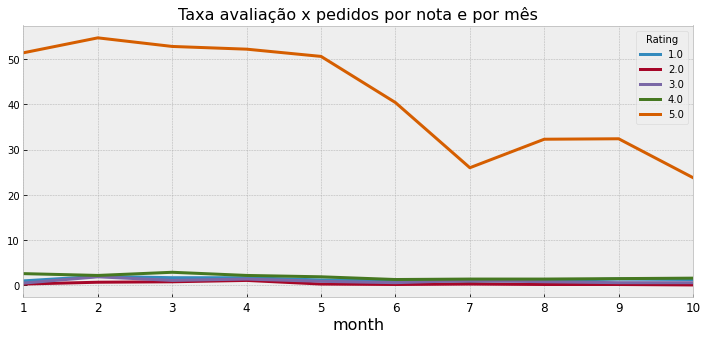

In [640]:
(respostas
 .pivot_table(index=['month'], columns=['Rating'], values='OrderID', aggfunc='count')
 .divide(Order_rating_DB.groupby('month')['OrderID'].count(), axis=0)
 .multiply(100)
 .round(1)
).plot(figsize=(12,5), title='Taxa avaliação x pedidos por nota e por mês', linewidth=3);

A taxa de avaliações 5 estrelas cai ao longo do ano, como já tínhamos observado em outros gráficos.<p></p>

Vamos ver a quantidade de pedidos para cada avaliação abaixo de 5 estrelas.

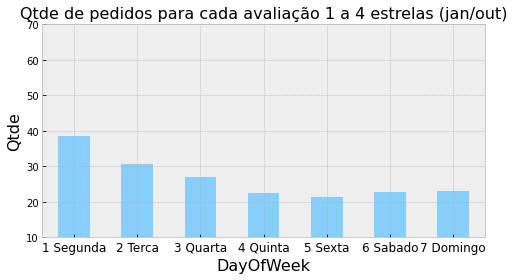

In [636]:
(Order_rating_DB.groupby('DayOfWeek')['OrderID'].count()
 .divide(respostas.query("Rating < 5").groupby('DayOfWeek')['OrderID'].count())
 .round(1)
).plot.bar(figsize=(7,4), ylim=(10, 70), color='lightskyblue', title='Qtde de pedidos para cada avaliação 1 a 4 estrelas (jan/out)') 
plt.xticks(rotation=0)
plt.ylabel('Qtde')
plt.tight_layout()
plt.savefig(IMAGES / 'ped_res_1_a_4_ano.png')

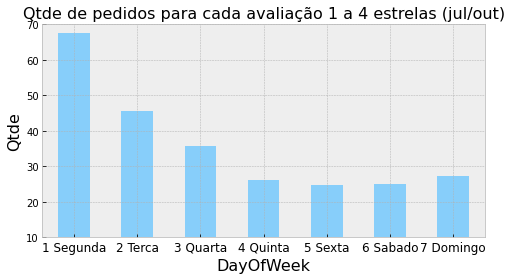

In [637]:
(Order_rating_DB.query("month >= 7").groupby('DayOfWeek')['OrderID'].count()
 .divide(respostas.query("Rating < 5 and month >= 7").groupby('DayOfWeek')['OrderID'].count())
 .round(1)
).plot.bar(figsize=(7,4), ylim=(10, 70), color='lightskyblue', title='Qtde de pedidos para cada avaliação 1 a 4 estrelas (jul/out)') 
plt.xticks(rotation=0)
plt.ylabel('Qtde')
plt.tight_layout()
plt.savefig(IMAGES / 'ped_res_1_a_4_jul_out.png')

Parece que a quantidade de pedidos aumenta mais que a quantidade de respostas a partir de maio. Vamos ver como essa taxa se comporta dependendo do dia da semana.

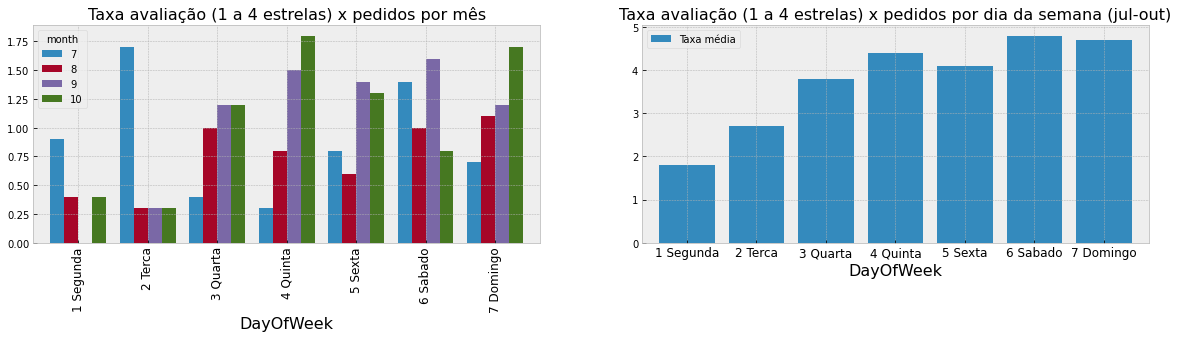

In [510]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
(respostas.query("Rating < 5 and month >= 7")
 .pivot_table(index=['DayOfWeek'], columns= 'month', values='OrderID', aggfunc='count', dropna=False)
 .divide(Order_rating_DB.groupby(['DayOfWeek'])['Rating'].count(), axis=0)
 .multiply(100)
 .round(1)
).plot.bar(ax=ax1, width=0.8, title='Taxa avaliação (1 a 4 estrelas) x pedidos por mês',)
plt.xticks(rotation=0);

(respostas.query("Rating < 5 and month >= 7")
 .pivot_table(index=['DayOfWeek'], values='OrderID', aggfunc='count', dropna=False)
 .divide(Order_rating_DB.groupby(['DayOfWeek'])['Rating'].count(), axis=0)
 .multiply(100)
 .round(1)
).plot.bar(ax=ax2, width=0.8, title='Taxa avaliação (1 a 4 estrelas) x pedidos por dia da semana (jul-out)',)
plt.xticks(rotation=0)
plt.legend(['Taxa média']);

Segunda, terça e quarta apresentam taxas menores. Ou seja, além de terem menos avaliações abaixo de 5 estrelas e menos pedidos, a relação avaliação x pedidos também é menor.
No caso da sexta, sábado e domingo, ocorre o oposto. Além de haver mais pedidos e mais avaliações abaixo de 5 estrelas, a relação avaliação x pedidos também é maior.

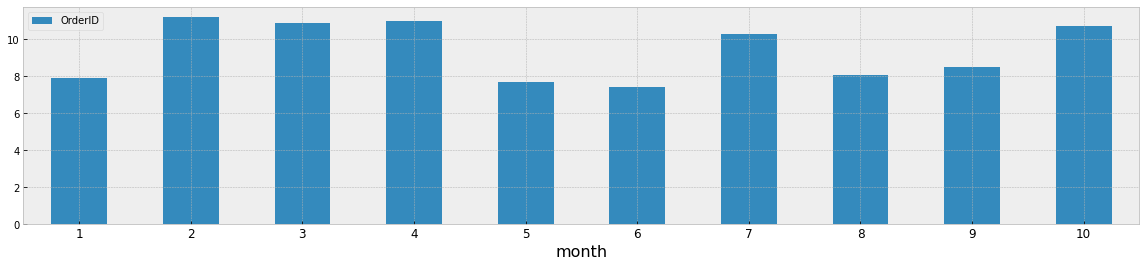

In [490]:
(respostas.query("Rating < 5")
 .pivot_table(index=['month'], values='OrderID', aggfunc='count', dropna=False)
 .divide(Order_rating_DB.groupby(['month'])['Rating'].count(), axis=0)
 .multiply(100)
 .round(1)
).plot.bar(figsize=(20,4))
plt.xticks(rotation=0);

Vamos ver a quantidade de respostas 5 estrelas (a que mais caiu de junho para julho) por dia da semana e período do dia, para ver se há algum padrão.

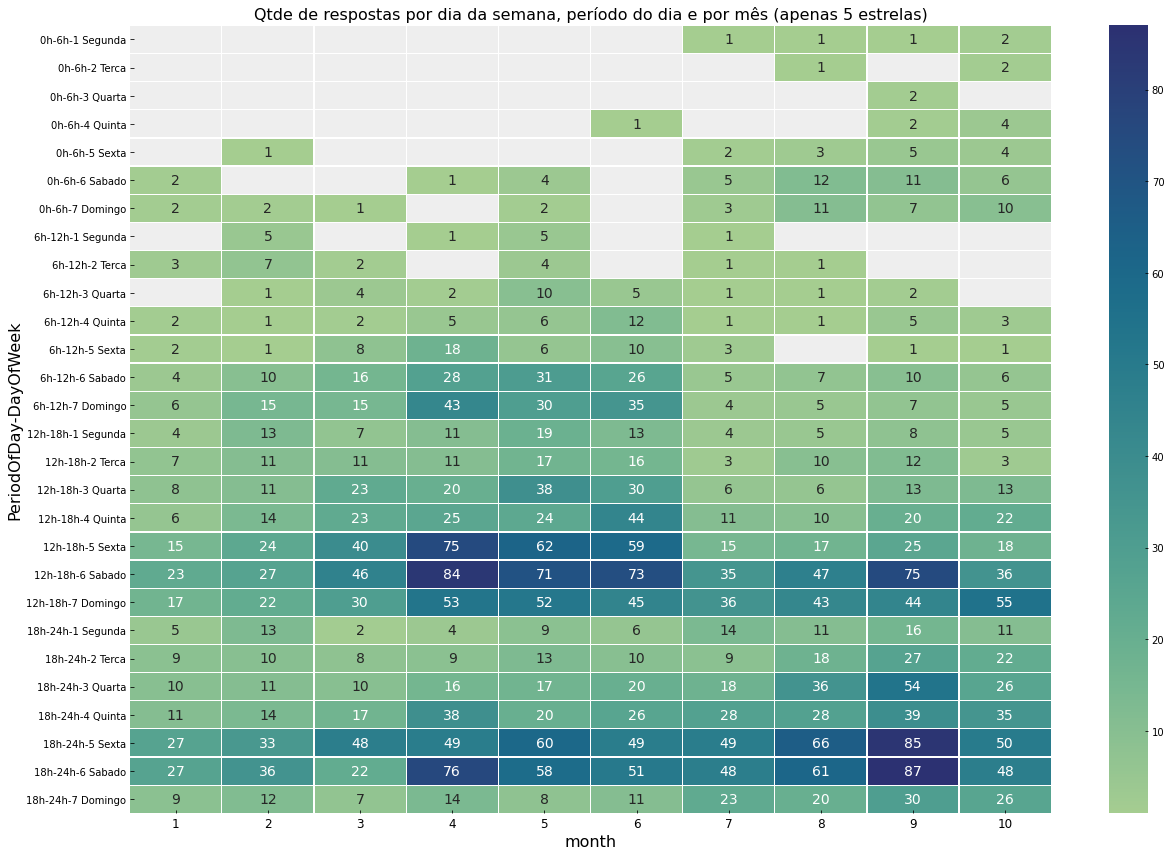

In [405]:
plt.figure(figsize=(18,12))
(sns.heatmap(
    (respostas.query("Rating == 5")
     .pivot_table(columns='month',
                  index=['PeriodOfDay', 'DayOfWeek'],
                  values='OrderID',
                  aggfunc='count')), 
    annot=True, 
    fmt='.0f', 
    linewidths=0.2,
    cmap="crest",
    annot_kws={"fontsize":14})
)
plt.title("Qtde de respostas por dia da semana, período do dia e por mês (apenas 5 estrelas)")
plt.tight_layout();

Aparentemente, não há padrão.

Agora, vamos ver a quantidade de respostas 1 a 4 estrelas (a que mais aumentou em agosto e setembro) por dia da semana e período do dia, para ver se há algum padrão.

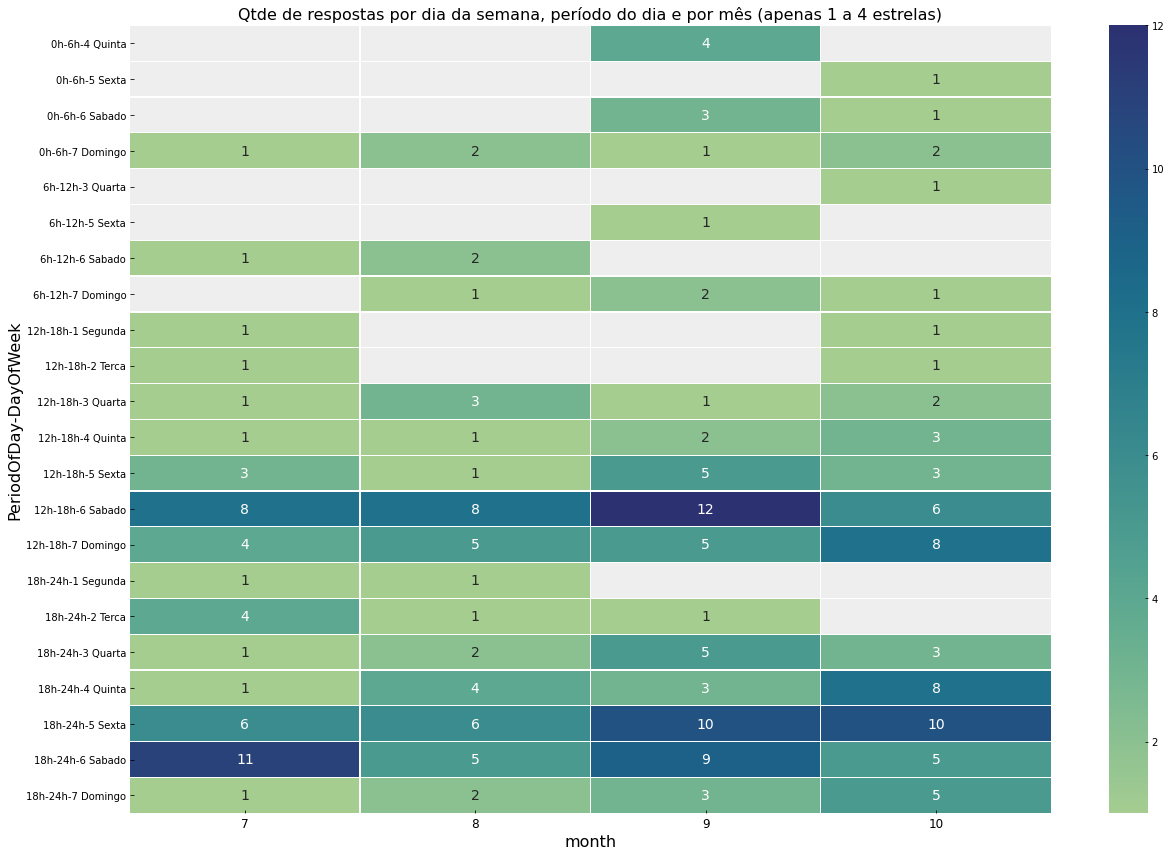

In [406]:
plt.figure(figsize=(18,12))
(sns.heatmap(
    (respostas.query("Rating != 5 and month >= 7")
     .pivot_table(columns='month',
                  index=['PeriodOfDay', 'DayOfWeek'],
                  values='OrderID',
                  aggfunc='count')), 
    annot=True, 
    fmt='.0f', 
    linewidths=0.2,
    cmap="crest",
    annot_kws={"fontsize":14})
)
plt.title("Qtde de respostas por dia da semana, período do dia e por mês (apenas 1 a 4 estrelas)")
plt.tight_layout();

- Aumento no período das 6h às 12h
- Aumento no período das 12h às 18h

##### Alguns ds insigths obtidos neste notebook foram colocados na apresentação.